![Alt text](./watson_image.png)




# <a id="asso-title"> Recommendations for Articles with IBM </a>


### Building a recommendation system for data science articles on the IBM Watson Studio. 

<br/> <br/>



## <a id="toc">  Table of Content. </a>

- Notebook I: Data Collection, Cleaning, and EDA.


- Notebook II: Rank-Based Recommendations and Neighbor Collaborative Filtering.


- Notebook III: Matrix Factorization Collaborative Filtering.


- Notebook IV: More EDA, Preprocessing, Content-based Recommendation.




## <a id="notebook1"> This is Notebook III: User-Item Matrix Factorization and Collaborative Filtering.</a>

0. [Data Loading.](#Loading)<br>


1. [Problem Framing](#Framing)<br>

     
2. [Data Preprocessing: user-item matrices.](#Preprocesssing)<br>

    2.1 train-test split.
    
    2.2 user-item matrix version 1.
    
    2.3 user-itme matrix version 2.
    

3. [Matrix Factorization.](#Factorization)<br>

    3.1 SVD for problem version 1.
    
    3.2 FunkSVD for problem version 2.

    
4. [Evaluation.](#save)<br>

In [1]:
# This is Python 3 environment, with Anaconda distribution of standard libraries.
# Additional module may needed: pickle.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split

%matplotlib inline
plt.style.use('seaborn')

## <a class="anchor" id="Loading"> 0. Data Loading.</a>

In [2]:
# Read a prepared dataset to start with

with open('1_data_df.pkl', 'rb') as pickle1:
    df = pickle.load(pickle1)

with open('1_data_df_content.pkl', 'rb') as pickle2:
    df_content = pickle.load(pickle2)
    
# overview of df
df.head()

,article_id,title,user_id
0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1314,healthcare python streaming application demo,2
2,1429,use deep learning for image classification,3
3,1338,ml optimization using cognitive assistant,4
4,1276,deploy your python model as a restful api,5


## <a class="anchor" id="Framing"> 1. Problem Framing.</a>

### Data Understanding

Our data consists of user-article interaction records. 

From the EDA below, we see that the numbers of interactions between an user and an article ranges from 1 to 40+, with majority (80%) being 1 and decays exponentially. (See the plots below.)

### Objective Understanding

Our goal in this notebook is to build a personalized recommendation algorithm using matrix factorization technique.


### Frame it as Machine Learning Tasks

With these understandings, we frame two different versions of the problem. We shall try out both versions.

- **Problem Version 1:** 

    (i). Train-test split the data.
    
    (ii). Transform the data into a user-item matrix consists of 1 and 0, indicating whether an user has interaction(s) with an article or not. (Same as in notebook II.)
    
    (iii). Use learn SVD from the training set, and evaluate the model on how well it recovers the testing data.
    

- **Problem Version 2:**

    (i). Train-test split the data.
    
    (ii). Transform the data into a user-item matrix consists of 1 and 0, indicating whether an user has interaction(s) with an article or not.
    
    (iii). Use learn SVD from the training set, and evaluate the model on how well it recovers the testing data.
    
    
- **Comparison and Limitations:**

    - For version 1, we use the value 0 to encode lack of interactions between an user with an article. In this way, we will not have missing values in the matrix and can use analytic SVD algorithm. 
    - However, lack of interaction may not align well with lack of potential interest. 
    
    - For version 2, we would use NaN to encode lack of interactions and present some uncertainty, which might be an advantage. 
    
    - However, there are problems with this version too.
        - First, the distribution of numbers of interaction has a very wide range and decays exponentially. We can counter this by trimming and transforming the data.
        - Second, it's not clear that the number of interactions is a good indicator of level of interest, and it may very much related to user reading habits or other factors.
        
    - We can use a gradient descent traning algorithm FunkSVD to learn SVD with missing values. See below for details.

### 1.1 Number of interactions per user-item



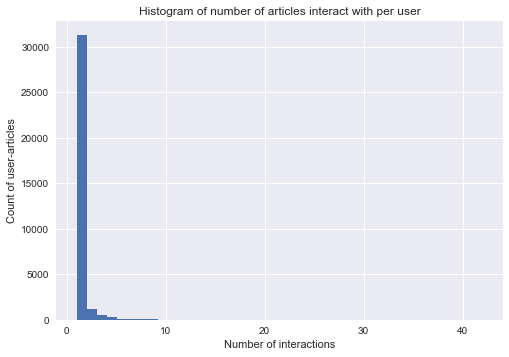

In [3]:
# group by user and item
grouped = df.groupby(['user_id','article_id'])
# interaction counts
n_interactions = grouped.count()['title']


# distribution of numbers of articles per user
plt.hist(n_interactions, bins=40)
plt.ylabel('Count of user-articles')
plt.xlabel('Number of interactions')
plt.title('Histogram of number of articles interact with per user')
plt.show()

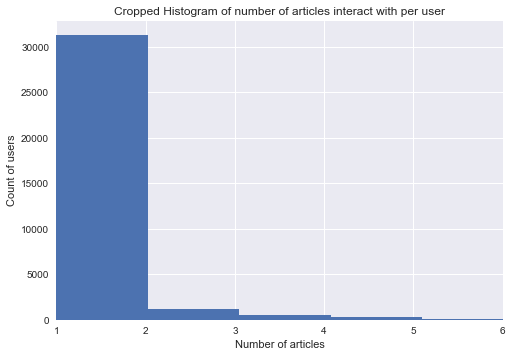

In [59]:
# distribution of numbers of articles from 1 to 10.
plt.hist(n_interactions, bins=40)
plt.xlim(1,6)
plt.ylabel('Count of users')
plt.xlabel('Number of articles')
plt.title('Cropped Histogram of number of articles interact with per user')
plt.show()

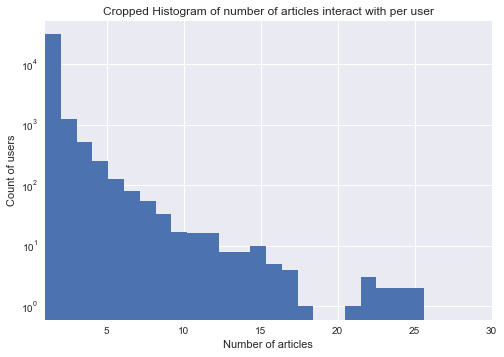

In [61]:
# distribution of numbers of articles from 1 to 10.
plt.hist(n_interactions, bins=40)
plt.xlim(1,30)
plt.ylabel('Count of users')
plt.yscale('log')
plt.xlabel('Number of articles')
plt.title('Cropped Histogram of number of articles interact with per user')
plt.show()

In [64]:
# percentage of values larger than 1
print(f'The percentage of entries larger than 1 is {sum(n_interactions>1)/len(n_interactions)}.')

The percentage of values larger than 1 is 0.19425806068523246.


## <a class="anchor" id="Preprocessing"> 2. Data Preprocessing.</a>

In this section, we prepare the two versions of user-item matrices. 

In both versions, we reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** appear in each **row** once.


* Each **article** show up in one **column**.  

The two versions of user-item matrices differ on their entries。




### 2.1 Train-Test Split Version 1.

We shall reserve part of data as test data, in order to evaluate our models.



### 2.2 Train-Test Split Version 2.



If a user has read exactly 1 article, and we reserve such a data point for testing, then we will not see this user in the training. **We shall choose test data from these users to avoid the "cold start" problem.**


Therefore, we recall the following EAD from Notebook I about the number of article read by each user.

### 2.1.1 Number of total interactions per user

We will see below that the percentage of users that read more than 1 article is 72%.

We shall choose the test data from these users. 

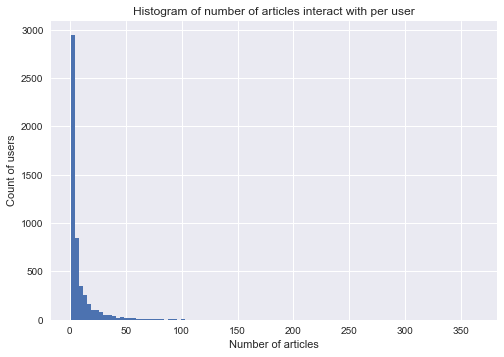

In [65]:
# group by user
grouped = df.groupby('user_id')
# article counts per user
n_articles_per_user = grouped.count()['article_id']


# distribution of numbers of articles per user
plt.hist(n_articles_per_user, bins=100)
plt.ylabel('Count of users')
plt.xlabel('Number of articles')
plt.title('Histogram of number of articles interact with per user')
plt.show()

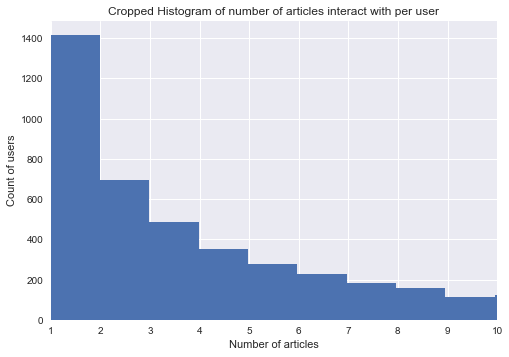

In [66]:
# distribution of numbers of articles from 1 to 10.
plt.hist(n_articles_per_user, bins=365)
plt.xlim(1,10)
plt.ylabel('Count of users')
plt.xlabel('Number of articles')
plt.title('Cropped Histogram of number of articles interact with per user')
plt.show()

#### Boxplot for viewing the tail

/Users/hchen/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


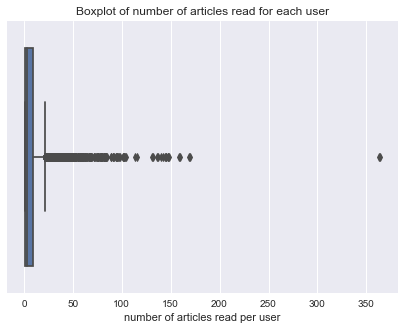

In [68]:
# boxplot
fig, ax = plt.subplots(figsize=(7,5))
ax=sns.boxplot(n_articles_per_user)
ax.set_xlabel('number of articles read per user')
plt.title('Boxplot of number of articles read for each user')
plt.show()

In [72]:
# percentage of users that read more than 1 article
print(f'The percentage of users that read more than 1 article is {sum(n_articles_per_user>1)/len(n_articles_per_user)}.')


The percentage of users that read more than 1 article is 0.724995144688289.


### 2.1.2 Train-test split for user-item.

In [4]:
n_interactions

user_id  article_id
1        43            1
         109           1
         151           1
         268           1
         310           2
                      ..
5146     1394          1
         1416          1
5147     233           1
5148     1160          1
5149     16            1
Name: title, Length: 33682, dtype: int64

In [5]:
df_n_interactions = pd.DataFrame(n_interactions).reset_index()

In [6]:
df_n_interactions

,user_id,article_id,title
0,1,43,1
1,1,109,1
2,1,151,1
3,1,268,1
4,1,310,2
...,...,...,...
33677,5146,1394,1
33678,5146,1416,1
33679,5147,233,1
33680,5148,1160,1


In [7]:
# data points where both user_id interact with more than 1 article_id.
df_dup = df_n_interactions[df_n_interactions.duplicated(subset=['user_id'])]

# we have enough these data points
len(df_dup)

28533

In [8]:
# select test data from df_dup
_, df_test = train_test_split(df_dup, test_size=0.25, random_state=5)

df_train = df_n_interactions.loc[[x for x in df_n_interactions.index.values if x not in df_test.index.values]]

df_train = df_train.set_index(['user_id','article_id'])
df_test = df_test.set_index(['user_id','article_id'])
# sanity check
len(df_n_interactions), len(df_train), len(df_test)

(33682, 26548, 7134)

In [9]:
df_train

title
user_id article_id       
1       43              1
        109             1
        151             1
        268             1
        310             2
...                   ...
5146    1394            1
        1416            1
5147    233             1
5148    1160            1
5149    16              1

[26548 rows x 1 columns]

### 2.2 Version 1 matrix.

For version 1, if a user has interacted with an article, then place a 1 where the user-row meets for that article-column, if a user has not interacted with an item, then place a zero where the user-row meets for that article-column. 

In [36]:
# we created version 1 in notebook2, we import a function to reproduce that.
from helper_functions import create_user_item_matrix

# create version 1 user-item matrix
_, user_item_train_1 = create_user_item_matrix(df_train)
_, user_item_test_1 = create_user_item_matrix(df_test)

In [37]:
user_item_train_1

article_id,0,2,4,8,9,12,14,15,16,18,...,1434,1435,1436,1437,1439,1440,1441,1442,1443,1444
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5146,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5147,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 2.3 Version 2 matrix.

For version 2, we count the number of interactions (as in df) between a user and an article and use the number as the entry at the corresponding row and column. If there is no interactions, we place an 'NaN'. 

We will trim the range of the numbers as the distribution has a long tail.





In [12]:
# define a function to make version 2 user-item matrix

def create_user_item_matrix_2(df, cap=4):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    cap - integer, the cap value in the matrix.
    log_transform - boolean, if true then apply log1p transform.
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # user item matrix with count values
    user_item_df = df.groupby(['user_id','article_id']).count().astype('int').unstack()
    # index column by item (row by user)
    user_item_df = user_item_df.droplevel(0, axis=1)
    # trim values larger than cap
    user_item_df = user_item_df.applymap(lambda x: min(x,cap))
        
    
    return user_item_df

In [13]:
user_item_train_2 = create_user_item_matrix_2(df_train)
user_item_test_2 = create_user_item_matrix_2(df_test)

In [14]:
user_item_test_2

article_id,12,14,15,16,18,20,26,28,29,32,...,1434,1435,1436,1437,1439,1440,1441,1442,1443,1444
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5140,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## <a class="anchor" id="Factorization"> 3. Matrix Factorization.</a>

In this section, we use matrix factorization to make recommendations to users.




### 3.1 Version 1.

In [38]:
# fit SVD on the user_item_train matrix
user_train_1, s_train_1, item_train_t_1 = np.linalg.svd(user_item_train_1, full_matrices=False)

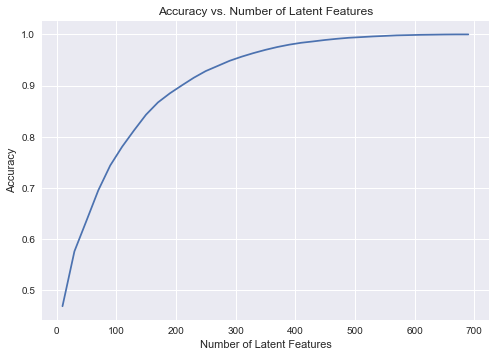

In [39]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train_1[:k]), user_train_1[:, :k], item_train_t_1[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_train_1, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

In [40]:
# use the training decomposition to predict on test data

df_user_train_1 = pd.DataFrame(user_train_1.T, columns=user_item_train_1.index.values)

df_item_train_1 = pd.DataFrame(item_train_t_1, columns=user_item_train_1.columns.values)

In [41]:


def predict_recs(user_ids, item_ids, user_matrix=df_user_train_1, s_matrix=s_train_1, 
                 item_matrix=df_item_train_1):
    """
    Produce recommendations for users based on a given matrix factorization.
    
    INPUT:
    user_ids - list: user ids to make recommendations for.
    item_ids - list: article ids to be selected for recommendations.
    
    user_matrix - pd.DataFrame: the user matrix from the SVD of training data, 
                  columns labelled by user id, must contain the given "user_ids"
                  
    s_matrix - np.array: the singular value matrix in the SVD of training data,
    
    item_matrix -  pd.DataFrame: the item matrix from the SVD of training data, 
                  columns labelled by item id, must contain the given "item_ids"
                  
    OUTPUT:
    user_item_pred - a user_item dataframe with 0 and 1 values, representing not recommended 
                     and recommended, respectively. Index is user_ids, column is item_ids.
    """
    
    user_array = user_matrix[user_ids].values
    item_array = item_matrix[item_ids].values
    
    if len(s_matrix.shape)==1:
        s_matrix = np.diag(s_matrix)
        
    user_item = user_array.T@s_matrix@item_array
    user_item_pred = (pd.DataFrame(user_item, index=user_ids, columns=item_ids)>.5)*1
    
    return user_item_pred

In [44]:
test_users = [x for x in user_item_test_1.index.values if x in user_item_train_1.index.values]
test_items = [x for x in user_item_test_1.columns.values if x in user_item_train_1.columns.values]

In [45]:
user_item_pred_1 = predict_recs(test_users, test_items)

In [46]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [48]:
accuracy_score(user_item_pred_1.values.flatten(), 
               user_item_test_1.loc[test_users, test_items].values.flatten())

0.9805908948866435

In [52]:
user_item_test_1.shape, user_item_train_1.shape

((2372, 605), (5149, 708))

### 3.2 version 2